#Natural Language Processing Project: Bias Detection in Text Classification

Natural Language Processing (NLP) is a rapidly evolving field within artificial intelligence, focusing on enabling computers to understand and interpret human language. This project explores the use of various machine learning models to classify text data, specifically identifying whether a given text contains sexist language. The method in which this information is obtained is called Biased Detection. This technique utilises sentiment analysis and opinion mining in text, social media, reviews, and customer feedback and other sources to dicern where biases lie.

It is also important to note that certain words or phrases may be associated with negative sentiments in some groups, for example women’s reviews of products might be classified as less genuine or emotional or models might misinterpret the context based on cultural or linguistic differences. The aim is to avoid such instances of false bias to make more accurate predictions.

A good thing to note is if the model classifies reviews differently based on the demographic characteristics of the reviewer like gender or ethnicity. This is key in identifying potential biases. The dataset used in this project consists of labeled text data that includes sentences marked as either "sexist" or "non-sexist".  

## Imports

In [1]:
!pip install nltk
!pip show nltk
!pip install tldextract
!pip install datasets
!pip install shap

Name: nltk
Version: 3.9.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.3 MB/s eta 0:00:00


In [2]:
import os
import requests
import json
import time
import zipfile

import nltk
import kagglehub
import re

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter

import tldextract

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.metrics import AUC, Precision, Recall

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tensorflow.keras.optimizers import Adam
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from imblearn.over_sampling import SMOTE
import shap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Getting the data

In [3]:
# Download latest version
path = kagglehub.dataset_download("aadyasingh55/sexism-detection-in-english-texts")

path = "/kaggle/input/sexism-detection-in-english-texts"
print("Path to dataset files:", path)

dev_df = pd.read_csv(f"{path}/dev.csv")
test_df = pd.read_csv(f"{path}/test (1).csv")
train_df = pd.read_csv(f"{path}/train (2).csv")


Path to dataset files: /kaggle/input/sexism-detection-in-english-texts


##Exploring the data

In [4]:
print("Train DF Info:")
train_df.info()
print("\nTrain DF Head:")
print(train_df.head())

print("\nDev DF Info:")
dev_df.info()
print("\nDev DF Head:")
print(dev_df.head())

print("\nTest DF Info:")
test_df.info()
print("\nTest DF Head:")
print(test_df.head())

Train DF Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
 5   split           14000 non-null  object
dtypes: object(6)
memory usage: 656.4+ KB

Train DF Head:
                  rewire_id  \
0  sexism2022_english-16993   
1  sexism2022_english-13149   
2  sexism2022_english-13021   
3  sexism2022_english-14998   
4   sexism2022_english-7228   

                                                text label_sexist  \
0                            Then, she's a keeper. 😉   not sexist   
1  This is like the Metallica video where the poo...   not sexist   
2                                             woman?   not sexist   
3  U

In [5]:
# Check for missing values
print("\nMissing values in Train DF:")
print(train_df.isnull().sum())
print("\nMissing values in Dev DF:")
print(dev_df.isnull().sum())
print("\nMissing values in Test DF:")
print(test_df.isnull().sum())


Missing values in Train DF:
rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64

Missing values in Dev DF:
rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64

Missing values in Test DF:
rewire_id         0
text              0
label_sexist      0
label_category    0
label_vector      0
split             0
dtype: int64


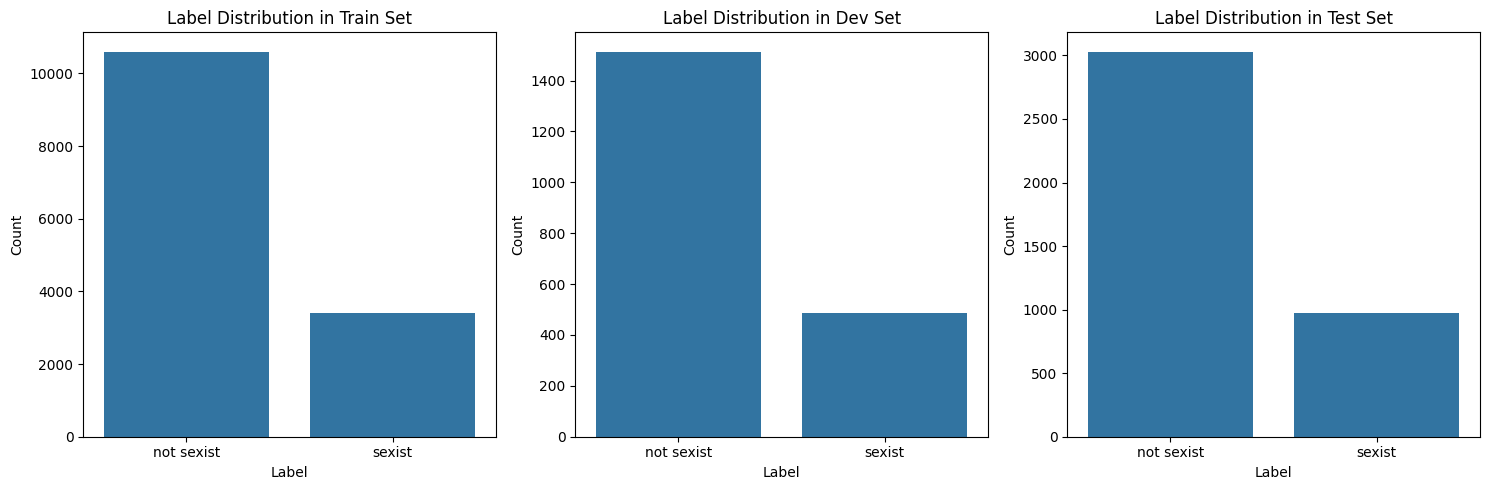

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x='label_sexist')
plt.title('Label Distribution in Train Set')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=dev_df, x='label_sexist')
plt.title('Label Distribution in Dev Set')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=test_df, x='label_sexist')
plt.title('Label Distribution in Test Set')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
def get_top_ngrams(corpus, n=1, top_k=20):
    words = re.findall(r'\b\w+\b', ' '.join(corpus).lower())
    if n == 1:
        return Counter(words).most_common(top_k)
    else:
        ngrams = []
        for i in range(len(words) - n + 1):
            ngrams.append(tuple(words[i:i+n]))
        return Counter(ngrams).most_common(top_k)

print(f"Unique values in 'label_sexist' column (Train Set): {train_df['label_sexist'].unique()}")
print(f"Unique values in 'label_sexist' column (Dev Set): {dev_df['label_sexist'].unique()}")
print(f"Unique values in 'label_sexist' column (Test Set): {test_df['label_sexist'].unique()}")


Unique values in 'label_sexist' column (Train Set): ['not sexist' 'sexist']
Unique values in 'label_sexist' column (Dev Set): ['not sexist' 'sexist']
Unique values in 'label_sexist' column (Test Set): ['not sexist' 'sexist']


In [8]:
positive_label_value = 'sexist'
negative_label_value = 'not sexist'

# Filter texts based on the 'label_sexist' column
sexist_texts_train = train_df[train_df['label_sexist'] == positive_label_value]['text']
non_sexist_texts_train = train_df[train_df['label_sexist'] == negative_label_value]['text']
sexist_texts_dev = dev_df[dev_df['label_sexist'] == positive_label_value]['text']
non_sexist_texts_dev = dev_df[dev_df['label_sexist'] == negative_label_value]['text']
sexist_texts_test = test_df[test_df['label_sexist'] == positive_label_value]['text']
non_sexist_texts_test = test_df[test_df['label_sexist'] == negative_label_value]['text']

total_texts_train = len(train_df)
total_texts_dev = len(dev_df)
total_texts_test = len(test_df)

# Get numerical counts
num_sexist_train = len(sexist_texts_train)
num_sexist_dev = len(sexist_texts_dev)
num_sexist_test = len(sexist_texts_test)

print(f"\nNumber of '{positive_label_value}' texts in train set: {len(sexist_texts_train)}")
print(f"Number of '{negative_label_value}' texts in train set: {len(non_sexist_texts_train)}")
print(f"Percentage of sexist text in train set: '{(num_sexist_train / total_texts_train) * 100}'")

print(f"\nNumber of '{positive_label_value}' texts in dev set: {len(sexist_texts_dev)}")
print(f"Number of '{negative_label_value}' texts in dev set: {len(non_sexist_texts_dev)}")
print(f"Percentage of sexist text in dev set: '{(num_sexist_dev / total_texts_dev) * 100}'")

print(f"\nNumber of '{positive_label_value}' texts in test set: {len(sexist_texts_test)}")
print(f"Number of '{negative_label_value}' texts in test set: {len(non_sexist_texts_test)}")
print(f"Percentage of sexist text in test set: '{(num_sexist_test / total_texts_test) * 100}'")

top_sexist_unigrams = get_top_ngrams(sexist_texts_train, n=1)
top_non_sexist_unigrams = get_top_ngrams(non_sexist_texts_train, n=1)
top_sexist_bigrams = get_top_ngrams(sexist_texts_train, n=2, top_k=10)
top_non_sexist_bigrams = get_top_ngrams(non_sexist_texts_train, n=2, top_k=10)


Number of 'sexist' texts in train set: 3398
Number of 'not sexist' texts in train set: 10602
Percentage of sexist text in train set: '24.271428571428572'

Number of 'sexist' texts in dev set: 486
Number of 'not sexist' texts in dev set: 1514
Percentage of sexist text in dev set: '24.3'

Number of 'sexist' texts in test set: 970
Number of 'not sexist' texts in test set: 3030
Percentage of sexist text in test set: '24.25'


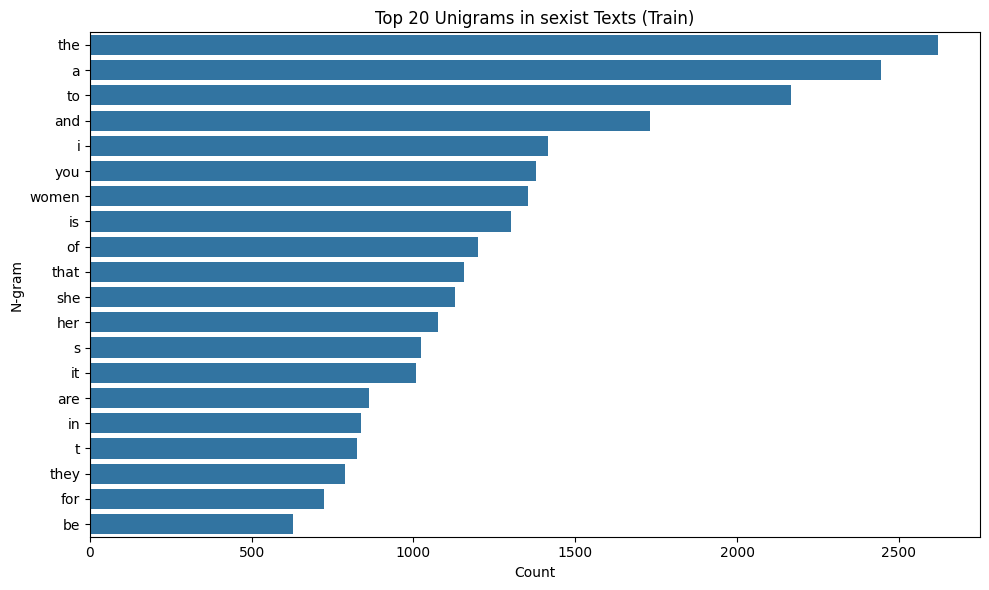

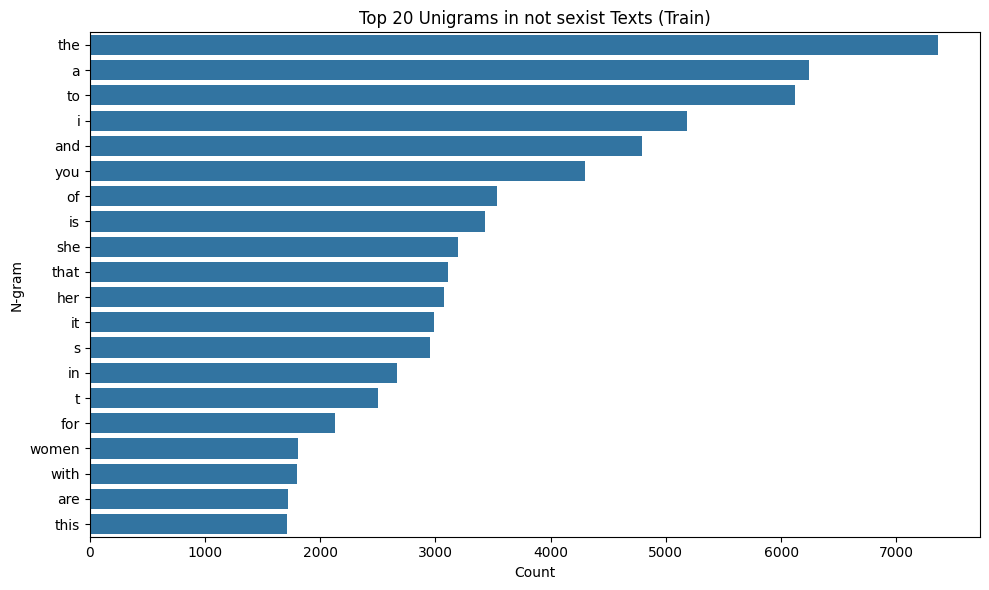

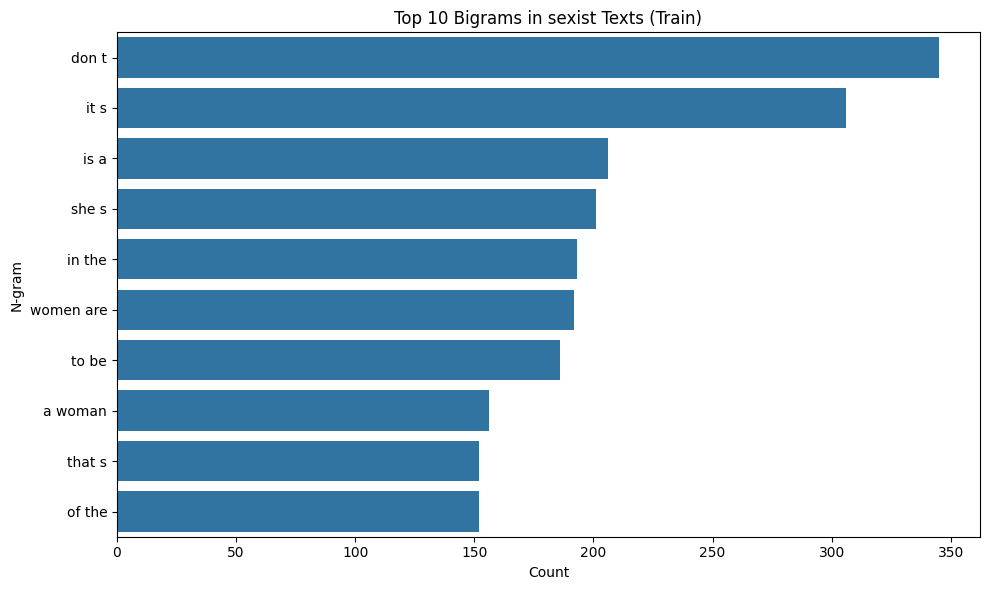

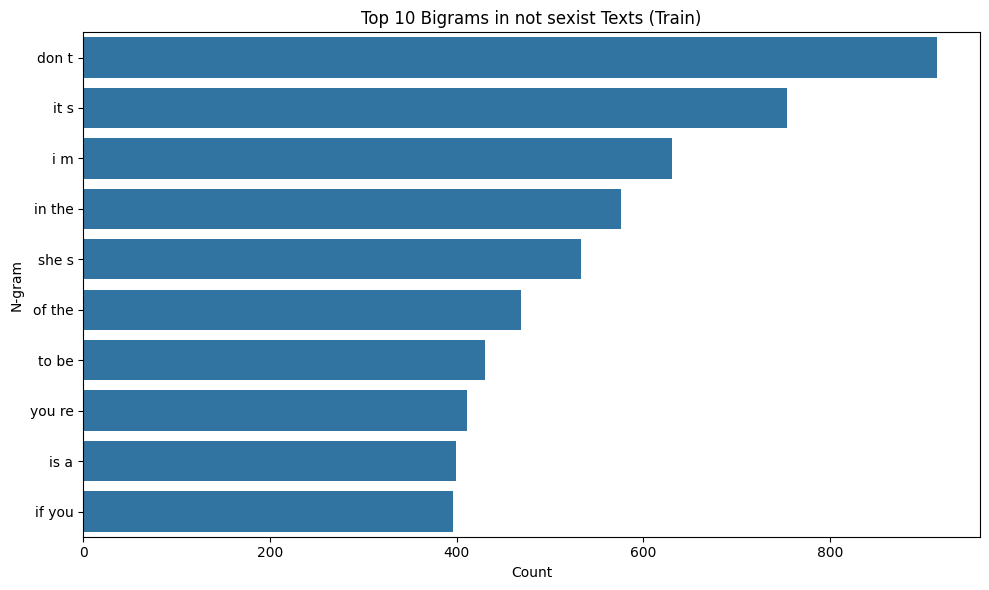

In [9]:
def plot_ngrams(ngram_list, title):
    if not ngram_list:
        print(f"No n-grams to plot for: {title}")
        return
    df_ngrams = pd.DataFrame(ngram_list, columns=['ngram', 'count'])

    # Convert ngram tuples to strings for better plotting
    if isinstance(df_ngrams['ngram'].iloc[0], tuple):
        df_ngrams['ngram'] = df_ngrams['ngram'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=df_ngrams.sort_values(by='count', ascending=False))
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

# Plotting
plot_ngrams(top_sexist_unigrams, f'Top 20 Unigrams in {positive_label_value} Texts (Train)')
plot_ngrams(top_non_sexist_unigrams, f'Top 20 Unigrams in {negative_label_value} Texts (Train)')
plot_ngrams(top_sexist_bigrams, f'Top 10 Bigrams in {positive_label_value} Texts (Train)')
plot_ngrams(top_non_sexist_bigrams, f'Top 10 Bigrams in {negative_label_value} Texts (Train)')


###Combining train and dev

In [10]:
train_dev_data= pd.concat([dev_df, train_df], ignore_index=True) # Combine datasets
train_dev_data= train_dev_data.sample(frac=1, random_state=1).reset_index(drop=True) # Shuffle the new dataset

train_dev_data['label_sexist'].value_counts()

,count
label_sexist,
not sexist,12116
sexist,3884


In [11]:
train_dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       16000 non-null  object
 1   text            16000 non-null  object
 2   label_sexist    16000 non-null  object
 3   label_category  16000 non-null  object
 4   label_vector    16000 non-null  object
 5   split           16000 non-null  object
dtypes: object(6)
memory usage: 750.1+ KB


In [12]:
train_dev_data.describe()

,rewire_id,text,label_sexist,label_category,label_vector,split
count,16000,16000,16000,16000,16000,16000
unique,16000,15999,2,5,12,2
top,sexism2022_english-11021,#NAME?,not sexist,none,none,train
freq,1,2,12116,12116,12116,14000


In [13]:
print(train_dev_data['label_category'].unique())

['none' '2. derogation' '1. threats, plans to harm and incitement'
 '3. animosity' '4. prejudiced discussions']


In [14]:
# Check for duplicate rows based on 'rewire_id' and 'text'
duplicate_entries = train_dev_data[train_dev_data.duplicated(subset=["rewire_id", "text"])]

# Display results
print(f"Number of duplicate rows based on 'rewire_id' and 'text': {duplicate_entries.shape[0]}")
print(duplicate_entries)

Number of duplicate rows based on 'rewire_id' and 'text': 0
Empty DataFrame
Columns: [rewire_id, text, label_sexist, label_category, label_vector, split]
Index: []


## Lemmatisation

In [15]:
# Initialise NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text and extract domains
def clean_text(text, lowercase=True, replace_urls=True, extract_domain=False, remove_stopwords=True, lemmatize=True):
    if lowercase:
        text = text.lower()

    # Extract domain names from URLs
    url_pattern = r'https?://\S+|www\.\S+'
    domains = []  # Store extracted domains
    matches = re.findall(url_pattern, text)

    for match in matches:
        extracted = tldextract.extract(match)
        domain = f"{extracted.domain}.{extracted.suffix}"  # e.g., "cnn.com"
        domains.append(domain)  # Save domain for analysis
        text = text.replace(match, "")  # Remove the URL from text

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens), domains  # Convert tokens back to string


In [16]:
# Apply function to dataset
train_dev_data[["text", "domains"]] = pd.DataFrame(train_dev_data["text"].apply(clean_text).tolist(), index=train_dev_data.index)

# Process the separate test set as well
test_df[["text", "domains"]] = pd.DataFrame(test_df["text"].apply(clean_text).tolist(), index=test_df.index)

print(train_dev_data.head())


                  rewire_id  \
0  sexism2022_english-14582   
1  sexism2022_english-15851   
2   sexism2022_english-6192   
3  sexism2022_english-17787   
4   sexism2022_english-2234   

                                                text label_sexist  \
0  user encountering gab sorry hear gab littered ...   not sexist   
1  way look woman object whats unattractive even ...   not sexist   
2                                      assume female   not sexist   
3                                 lol weak found mom   not sexist   
4  ultra rightwing pundit tweeted support kgb num...   not sexist   

  label_category label_vector  split domains  
0           none         none  train      []  
1           none         none  train      []  
2           none         none  train      []  
3           none         none  train      []  
4           none         none  train      []  


In [17]:
# Check which unique domains were extracted
unique_domains = pd.Series([domain for domain_list in train_dev_data['domains'] for domain in domain_list]).value_counts()
print(unique_domains.head(10))  # Display top 10 most frequent domains

www.                      1
look.                     1
nowhitesallowed,com.      1
state.ms.us               1
worldwideweirdnews.com    1
reddit.com                1
those.                    1
dallasnews.com            1
Name: count, dtype: int64


In [18]:
# Ensures mixed precision is set globally (allows for 16bit and 32bit float types (runs faster uses less memory))
set_global_policy('mixed_float16')

#Model Development

##Prep

### Intitalisation

In [19]:
# Initialize MultiLabelBinarizer for domains (fit on combined train_dev_data)
mlb = MultiLabelBinarizer()
domain_features_train = mlb.fit_transform(train_dev_data["domains"])

# Vectorize the cleaned text using TF-IDF (fit on combined train_dev_data)
vectorizer = TfidfVectorizer(max_features=5000)
X_text_train = vectorizer.fit_transform(train_dev_data["text"])
X_combined_train = hstack([X_text_train, domain_features_train])

# Encode the target variable for deep learning models
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(train_dev_data['label_sexist'])


# --- Prepare the separate TEST set features ---
domain_features_test = mlb.transform(test_df["domains"]) # Use fitted MLB
X_text_test = vectorizer.transform(test_df["text"]) # Use fitted TF-IDF Vectorizer
X_combined_test = hstack([X_text_test, domain_features_test])
y_encoded_test = label_encoder.transform(test_df['label_sexist'])


# Tokenize for deep learning models (fit on combined train_dev_data)
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_dev_data['text'])
X_seq_train = tokenizer.texts_to_sequences(train_dev_data['text'])

VOCAB_SIZE_DEEP_LEARNING = len(tokenizer.word_index) + 1
if tokenizer.num_words is not None:
    VOCAB_SIZE_DEEP_LEARNING = min(VOCAB_SIZE_DEEP_LEARNING, tokenizer.num_words + 1)

# Determine maxlen for padding based on train_dev_data
percentile_95 = int(np.percentile([len(seq) for seq in X_seq_train], 95))
MAX_SEQUENCE_LENGTH = percentile_95
X_pad_train = pad_sequences(X_seq_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Tokenize and pad the separate TEST set for deep learning models
X_seq_test = tokenizer.texts_to_sequences(test_df['text'])
X_pad_test = pad_sequences(X_seq_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['foxnews.com', 'holocaustdeprogrammingcourse.com'] will be ignored
  warnings.warn(


### Storage

In [20]:
# Define common variables for cross-validation
n_splits = 10 # Number of folds for StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # Set random_state for reproducibility of splits

# Initialise results
results = {
  "LR_Text": [],
  "LR_Domains": [],
  "NB": [],
  "RF": [],
  "SVM": [],
  "LSTM": [],
  "CNN": [],
  "BERT": [],
  "NBft": [],
}

# Initialize history storage for deep learning models (for plotting average curves)
avg_histories = {
    "CNN": {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': [],
        'precision': [], 'recall': [], 'val_precision': [], 'val_recall': [],
        'learning_rate': []},
    "LSTM": {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': [],
        'precision': [], 'recall': [], 'val_precision': [], 'val_recall': [],
        'learning_rate': []},
    "BERT": {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": [], "learning_rate": []},
}

# Initialize lists for additional metrics for each model
precision_list_lr_text, recall_list_lr_text, f1_list_lr_text = [], [], []
precision_list_lr_combined, recall_list_lr_combined, f1_list_lr_combined = [], [], []
precision_list_nb, recall_list_nb, f1_list_nb = [], [], []
precision_list_rf, recall_list_rf, f1_list_rf = [], [], []
precision_list_svm, recall_list_svm, f1_list_svm = [], [], []
precision_list_cnn, recall_list_cnn, f1_list_cnn = [], [], []
precision_list_lstm, recall_list_lstm, f1_list_lstm = [], [], []
precision_list_bert, recall_list_bert, f1_list_bert = [], [], []
precision_list_nbft, recall_list_nbft, f1_list_nbft = [], [], []

# Initialize confusion matrix sums (ensure they are reset or properly scoped for each model)
conf_matrix_sum_lr_text = np.zeros((2, 2))
conf_matrix_sum_lr_combined = np.zeros((2, 2))
conf_matrix_sum_nb = np.zeros((2, 2))
conf_matrix_sum_rf = np.zeros((2, 2))
conf_matrix_sum_svm = np.zeros((2, 2))
conf_matrix_sum_cnn = np.zeros((2, 2))
conf_matrix_sum_lstm = np.zeros((2, 2))
conf_matrix_sum_bert = np.zeros((2, 2))
conf_matrix_sum_nbft = np.zeros((2, 2))


## Machine Learning models

###Logisitc Regression


--- Training Logistic Regression Models ---

Logistic Regression - Fold 1/10...
  LR (Text Only) - Accuracy: 0.8306, Precision: 0.8421, Recall: 0.3711, F1 Score: 0.5152
  LR (Domains) - Accuracy: 0.8306, Precision: 0.8421, Recall: 0.3711, F1 Score: 0.5152

Logistic Regression - Fold 2/10...
  LR (Text Only) - Accuracy: 0.8206, Precision: 0.7988, Recall: 0.3479, F1 Score: 0.4847
  LR (Domains) - Accuracy: 0.8206, Precision: 0.7988, Recall: 0.3479, F1 Score: 0.4847

Logistic Regression - Fold 3/10...
  LR (Text Only) - Accuracy: 0.8350, Precision: 0.8780, Recall: 0.3711, F1 Score: 0.5217
  LR (Domains) - Accuracy: 0.8350, Precision: 0.8780, Recall: 0.3711, F1 Score: 0.5217

Logistic Regression - Fold 4/10...
  LR (Text Only) - Accuracy: 0.8244, Precision: 0.8204, Recall: 0.3531, F1 Score: 0.4937
  LR (Domains) - Accuracy: 0.8237, Precision: 0.8155, Recall: 0.3531, F1 Score: 0.4928

Logistic Regression - Fold 5/10...
  LR (Text Only) - Accuracy: 0.8263, Precision: 0.8274, Recall: 0.3582,

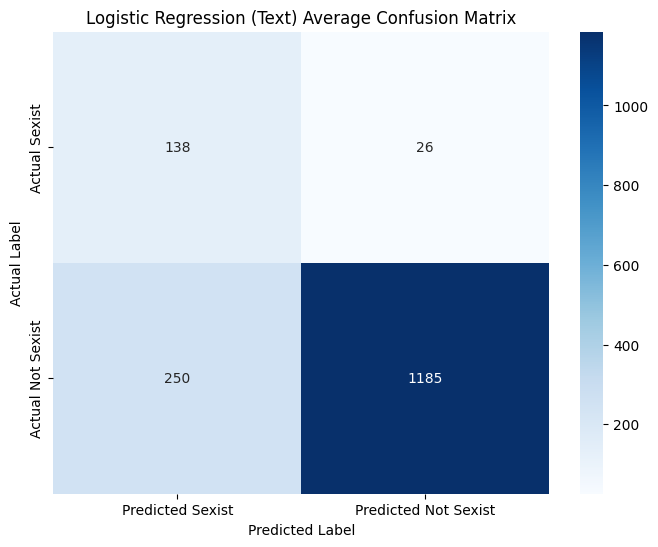

Logistic Regression (Text) Average Confusion Matrix:
 [[ 138   26]
 [ 250 1185]]

Average Accuracy for Logistic Regression (with Domains) over 10 folds: 0.8273 ± 0.0043
  Avg Precision: 0.8389, Avg Recall: 0.3571, Avg F1 Score: 0.5008


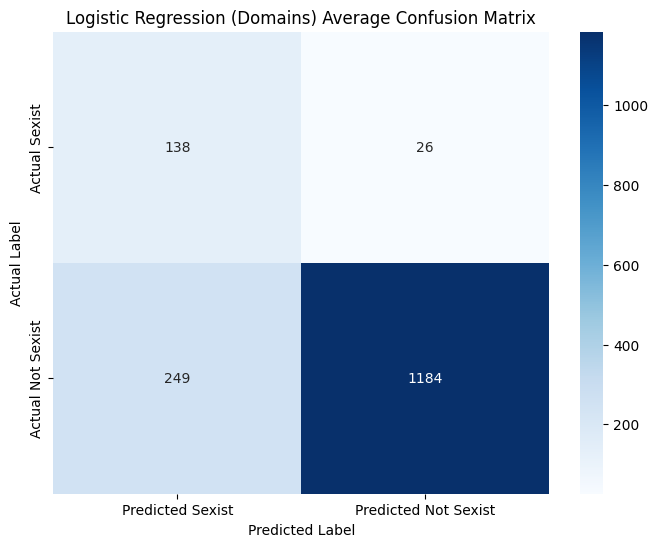

Logistic Regression (Domains) Average Confusion Matrix:
 [[ 138   26]
 [ 249 1184]]


In [21]:
print("\n--- Training Logistic Regression Models ---")

# Separate loop for Logistic Regression
for fold, (train_index, test_index) in enumerate(skf.split(X_text_train, y_encoded_train)):
    print(f"\nLogistic Regression - Fold {fold + 1}/{n_splits}...")

    # Ensure X_text_train_dev and X_combined_train_dev are in a sliceable sparse format (like CSR)
    X_text_train_csr = X_text_train.tocsr()
    X_combined_train_csr = X_combined_train.tocsr()


    # Splits for text-only Logistic Regression
    X_train_lr_text, X_test_lr_text = X_text_train_csr[train_index], X_text_train_csr[test_index]
    y_train_lr, y_test_lr = y_encoded_train[train_index], y_encoded_train[test_index]

    # Splits for combined-features Logistic Regression
    X_train_lr_combined, X_test_lr_combined = X_combined_train_csr[train_index], X_combined_train_csr[test_index]
    # y_train_lr and y_test_lr are the same for combined model

    # Logistic Regression (Text only)
    lr_model_t = LogisticRegression(max_iter=1000)
    lr_model_t.fit(X_train_lr_text, y_train_lr)
    y_pred_t = lr_model_t.predict(X_test_lr_text)
    acc_t = accuracy_score(y_test_lr, y_pred_t)
    results["LR_Text"].append(acc_t)

    precision_t, recall_t, f1_t, _ = precision_recall_fscore_support(y_test_lr, y_pred_t, average='binary', pos_label=1)
    precision_list_lr_text.append(precision_t)
    recall_list_lr_text.append(recall_t)
    f1_list_lr_text.append(f1_t)
    conf_matrix_sum_lr_text += confusion_matrix(y_test_lr, y_pred_t)

    print(f"  LR (Text Only) - Accuracy: {acc_t:.4f}, Precision: {precision_t:.4f}, Recall: {recall_t:.4f}, F1 Score: {f1_t:.4f}")

    # Logistic Regression (Combined features)
    lr_model_c = LogisticRegression(max_iter=1000)
    lr_model_c.fit(X_train_lr_combined, y_train_lr)
    y_pred_c = lr_model_c.predict(X_test_lr_combined)
    acc_c = accuracy_score(y_test_lr, y_pred_c)
    results["LR_Domains"].append(acc_c)

    precision_c, recall_c, f1_c, _ = precision_recall_fscore_support(y_test_lr, y_pred_c, average='binary', pos_label=1)
    precision_list_lr_combined.append(precision_c)
    recall_list_lr_combined.append(recall_c)
    f1_list_lr_combined.append(f1_c)
    conf_matrix_sum_lr_combined += confusion_matrix(y_test_lr, y_pred_c)

    print(f"  LR (Domains) - Accuracy: {acc_c:.4f}, Precision: {precision_c:.4f}, Recall: {recall_c:.4f}, F1 Score: {f1_c:.4f}")


# Calculate and print average results for LR (including new metrics)
avg_accuracy_T = np.mean(results["LR_Text"])
std_accuracy_T = np.std(results["LR_Text"])
avg_precision_T = np.mean(precision_list_lr_text)
avg_recall_T = np.mean(recall_list_lr_text)
avg_f1_T = np.mean(f1_list_lr_text)

avg_accuracy_C = np.mean(results["LR_Domains"])
std_accuracy_C = np.std(results["LR_Domains"])
avg_precision_C = np.mean(precision_list_lr_combined)
avg_recall_C = np.mean(recall_list_lr_combined)
avg_f1_C = np.mean(f1_list_lr_combined)


# Text Only
print(f"\nAverage Accuracy for Logistic Regression (Text only) over {n_splits} folds: {avg_accuracy_T:.4f} ± {std_accuracy_T:.4f}")
print(f"  Avg Precision: {avg_precision_T:.4f}, Avg Recall: {avg_recall_T:.4f}, Avg F1 Score: {avg_f1_T:.4f}")

# Plotting average confusion matrix for LR_Combined
avg_conf_matrix_lr_text = conf_matrix_sum_lr_text / n_splits
conf_matrix_custom_lr_text = np.array([[avg_conf_matrix_lr_text[1, 1], avg_conf_matrix_lr_text[0, 1]],
                                          [avg_conf_matrix_lr_text[1, 0], avg_conf_matrix_lr_text[0, 0]]], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_lr_text, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"],
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Logistic Regression (Text) Average Confusion Matrix")
plt.show()
print("Logistic Regression (Text) Average Confusion Matrix:\n", conf_matrix_custom_lr_text)


# Domains included
print(f"\nAverage Accuracy for Logistic Regression (with Domains) over {n_splits} folds: {avg_accuracy_C:.4f} ± {std_accuracy_C:.4f}")
print(f"  Avg Precision: {avg_precision_C:.4f}, Avg Recall: {avg_recall_C:.4f}, Avg F1 Score: {avg_f1_C:.4f}")

# Plotting average confusion matrix for LR_Combined
avg_conf_matrix_lr_combined = conf_matrix_sum_lr_combined / n_splits
conf_matrix_custom_lr_combined = np.array([[avg_conf_matrix_lr_combined[1, 1], avg_conf_matrix_lr_combined[0, 1]],
                                          [avg_conf_matrix_lr_combined[1, 0], avg_conf_matrix_lr_combined[0, 0]]], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_lr_combined, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"],
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Logistic Regression (Domains) Average Confusion Matrix")
plt.show()
print("Logistic Regression (Domains) Average Confusion Matrix:\n", conf_matrix_custom_lr_combined)

### Random Forrest


--- Training Random Forest Model ---

 Random Forest - Fold 1/10...
  Accuracy: 0.8350
  Precision: 0.8780
  Recall: 0.3711
  F1 Score: 0.5217

 Random Forest - Fold 2/10...
  Accuracy: 0.8337
  Precision: 0.8720
  Recall: 0.3686
  F1 Score: 0.5181

 Random Forest - Fold 3/10...
  Accuracy: 0.8425
  Precision: 0.8820
  Recall: 0.4046
  F1 Score: 0.5548

 Random Forest - Fold 4/10...
  Accuracy: 0.8350
  Precision: 0.8690
  Recall: 0.3763
  F1 Score: 0.5252

 Random Forest - Fold 5/10...
  Accuracy: 0.8469
  Precision: 0.9040
  Recall: 0.4124
  F1 Score: 0.5664

 Random Forest - Fold 6/10...
  Accuracy: 0.8269
  Precision: 0.8535
  Recall: 0.3454
  F1 Score: 0.4917

 Random Forest - Fold 7/10...
  Accuracy: 0.8325
  Precision: 0.8854
  Recall: 0.3573
  F1 Score: 0.5092

 Random Forest - Fold 8/10...
  Accuracy: 0.8375
  Precision: 0.8862
  Recall: 0.3805
  F1 Score: 0.5324

 Random Forest - Fold 9/10...
  Accuracy: 0.8337
  Precision: 0.8773
  Recall: 0.3676
  F1 Score: 0.5181

 Random

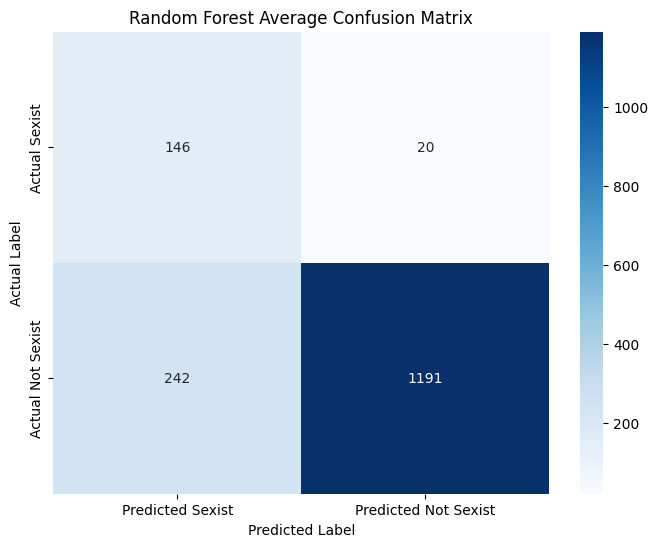

Random Forest Average Confusion Matrix:
 [[ 146   20]
 [ 242 1191]]


In [22]:
print("\n--- Training Random Forest Model ---")

# Separate loop for Random Forest
for fold, (train_index, test_index) in enumerate(skf.split(X_text_train, train_dev_data["label_sexist"])):
    print(f"\n Random Forest - Fold {fold + 1}/{n_splits}...")

    # Ensure X_text_train_dev is in CSR format
    X_text_train_csr = X_text_train.tocsr()

    # Splits for Random Forest (uses text only)
    X_train_rf, X_test_rf = X_text_train_csr[train_index], X_text_train_csr[test_index]
    y_train_rf, y_test_rf = y_encoded_train[train_index], y_encoded_train[test_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf_model.predict(X_test_rf)
    acc_rf = accuracy_score(y_test_rf, y_pred_rf)

    # Calculate precision, recall, f1 (ensure pos_label matches encoded value for 'sexist')
    # Assuming 'sexist' is encoded as 1 and 'not sexist' as 0
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_rf, y_pred_rf, average='binary', pos_label=1)
    precision_list_rf.append(precision)
    recall_list_rf.append(recall)
    f1_list_rf.append(f1)

    results["RF"].append(acc_rf)
    print(f"  Accuracy: {acc_rf:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    # Accumulate confusion matrix
    conf_matrix_sum_rf += confusion_matrix(y_test_rf, y_pred_rf)



# Calculate and print average results for RF
avg_accuracy_rf = np.mean(results["RF"])
std_accuracy_rf = np.std(results["RF"])
print(f"\nAverage Accuracy for Random Forest (RF) over {n_splits} folds: {avg_accuracy_rf:.4f} ± {std_accuracy_rf:.4f}")

# Plotting average confusion matrix for RF (same as your original, just use the _rf suffix)
avg_conf_matrix_rf = conf_matrix_sum_rf / n_splits
conf_matrix_custom_rf = np.array([[avg_conf_matrix_rf[1, 1], avg_conf_matrix_rf[0, 1]],
                                 [avg_conf_matrix_rf[1, 0], avg_conf_matrix_rf[0, 0]]], dtype=int)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_rf, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"], # Corrected labels
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"]) # Corrected labels
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Random Forest Average Confusion Matrix")
plt.show()

print("Random Forest Average Confusion Matrix:\n", conf_matrix_custom_rf)

### Naive Bayes


--- Training Naive Bayes Model ---

Naive Bayes - Fold 1/10...
  Naive Bayes - Accuracy: 0.7944, Precision: 0.9275, Recall: 0.1649, F1 Score: 0.2801

Naive Bayes - Fold 2/10...
  Naive Bayes - Accuracy: 0.7881, Precision: 0.8769, Recall: 0.1469, F1 Score: 0.2517

Naive Bayes - Fold 3/10...
  Naive Bayes - Accuracy: 0.7900, Precision: 0.9333, Recall: 0.1443, F1 Score: 0.2500

Naive Bayes - Fold 4/10...
  Naive Bayes - Accuracy: 0.7944, Precision: 0.9155, Recall: 0.1675, F1 Score: 0.2832

Naive Bayes - Fold 5/10...
  Naive Bayes - Accuracy: 0.7875, Precision: 0.8871, Recall: 0.1418, F1 Score: 0.2444

Naive Bayes - Fold 6/10...
  Naive Bayes - Accuracy: 0.7881, Precision: 0.8657, Recall: 0.1495, F1 Score: 0.2549

Naive Bayes - Fold 7/10...
  Naive Bayes - Accuracy: 0.7875, Precision: 0.9153, Recall: 0.1388, F1 Score: 0.2411

Naive Bayes - Fold 8/10...
  Naive Bayes - Accuracy: 0.7869, Precision: 0.8871, Recall: 0.1414, F1 Score: 0.2439

Naive Bayes - Fold 9/10...
  Naive Bayes - Accuracy

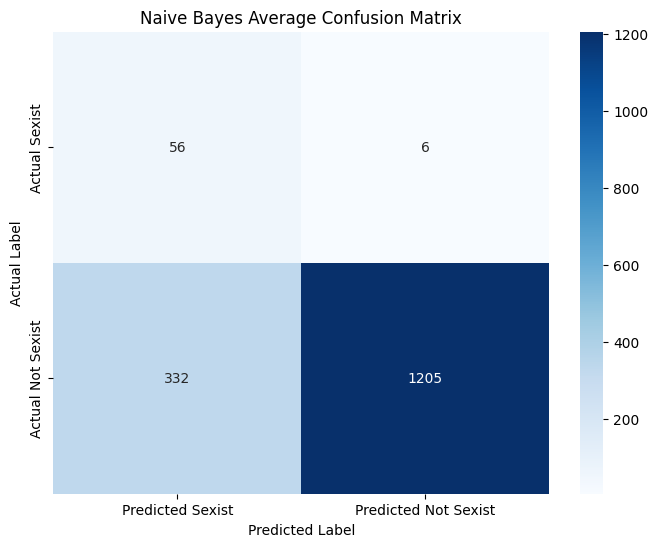

Naive Bayes Average Confusion Matrix:
 [[  56    6]
 [ 332 1205]]


In [23]:
print("\n--- Training Naive Bayes Model ---")

# Separate loop for Naive Bayes
for fold, (train_index, test_index) in enumerate(skf.split(X_text_train, y_encoded_train)):
    print(f"\nNaive Bayes - Fold {fold + 1}/{n_splits}...")

    # Ensure X_text_train_dev is in CSR format
    X_text_train_csr = X_text_train.tocsr()

    # Splits for Naive Bayes (uses text only)
    X_train_nb, X_test_nb = X_text_train_csr[train_index], X_text_train_csr[test_index]
    y_train_nb, y_test_nb = y_encoded_train[train_index], y_encoded_train[test_index]

    nb_model = MultinomialNB()
    nb_model.fit(X_train_nb, y_train_nb)
    y_pred_nb = nb_model.predict(X_test_nb)
    acc_nb = accuracy_score(y_test_nb, y_pred_nb)
    results["NB"].append(acc_nb)

    precision_nb_f, recall_nb_f, f1_nb_f, _ = precision_recall_fscore_support(y_test_nb, y_pred_nb, average='binary', pos_label=1)
    precision_list_nb.append(precision_nb_f)
    recall_list_nb.append(recall_nb_f)
    f1_list_nb.append(f1_nb_f)
    conf_matrix_sum_nb += confusion_matrix(y_test_nb, y_pred_nb)

    print(f"  Naive Bayes - Accuracy: {acc_nb:.4f}, Precision: {precision_nb_f:.4f}, Recall: {recall_nb_f:.4f}, F1 Score: {f1_nb_f:.4f}")

# Calculate and print average results for NB
avg_accuracy_nb = np.mean(results["NB"])
std_accuracy_nb = np.std(results["NB"])
avg_precision_nb = np.mean(precision_list_nb)
avg_recall_nb = np.mean(recall_list_nb)
avg_f1_nb = np.mean(f1_list_nb)

print(f"\nAverage Accuracy for Naive Bayes (NB) over {n_splits} folds: {avg_accuracy_nb:.4f} ± {std_accuracy_nb:.4f}")
print(f"  Avg Precision: {avg_precision_nb:.4f}, Avg Recall: {avg_recall_nb:.4f}, Avg F1 Score: {avg_f1_nb:.4f}")

# Plotting average confusion matrix for NB
avg_conf_matrix_nb = conf_matrix_sum_nb / n_splits
conf_matrix_custom_nb = np.array([[avg_conf_matrix_nb[1, 1], avg_conf_matrix_nb[0, 1]],
                                 [avg_conf_matrix_nb[1, 0], avg_conf_matrix_nb[0, 0]]], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_nb, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"],
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Naive Bayes Average Confusion Matrix")
plt.show()
print("Naive Bayes Average Confusion Matrix:\n", conf_matrix_custom_nb)

### SVM


--- Training SVM Model ---

SVM - Fold 1/10...
  SVM - Accuracy: 0.8369, Precision: 0.8588, Recall: 0.3918, F1 Score: 0.5381

SVM - Fold 2/10...
  SVM - Accuracy: 0.8394, Precision: 0.8922, Recall: 0.3840, F1 Score: 0.5369

SVM - Fold 3/10...
  SVM - Accuracy: 0.8406, Precision: 0.8889, Recall: 0.3918, F1 Score: 0.5438

SVM - Fold 4/10...
  SVM - Accuracy: 0.8319, Precision: 0.8400, Recall: 0.3789, F1 Score: 0.5222

SVM - Fold 5/10...
  SVM - Accuracy: 0.8394, Precision: 0.8830, Recall: 0.3892, F1 Score: 0.5403

SVM - Fold 6/10...
  SVM - Accuracy: 0.8275, Precision: 0.8590, Recall: 0.3454, F1 Score: 0.4926

SVM - Fold 7/10...
  SVM - Accuracy: 0.8344, Precision: 0.8605, Recall: 0.3805, F1 Score: 0.5276

SVM - Fold 8/10...
  SVM - Accuracy: 0.8350, Precision: 0.8492, Recall: 0.3907, F1 Score: 0.5352

SVM - Fold 9/10...
  SVM - Accuracy: 0.8350, Precision: 0.8882, Recall: 0.3676, F1 Score: 0.5200

SVM - Fold 10/10...
  SVM - Accuracy: 0.8375, Precision: 0.8772, Recall: 0.3856, F1 Score

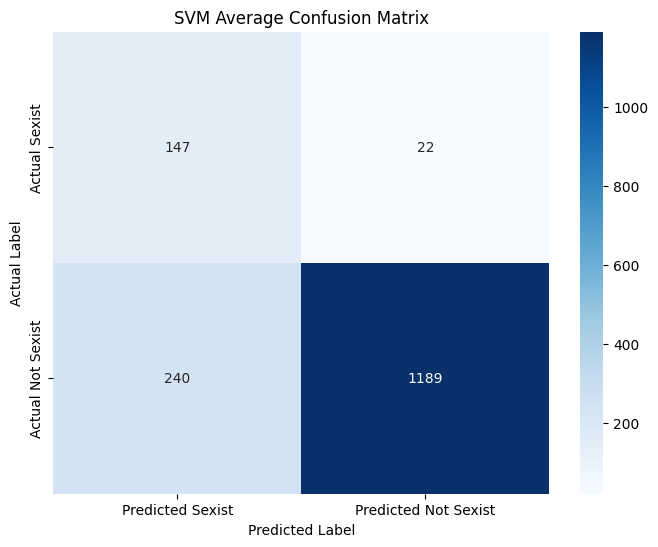

SVM Average Confusion Matrix:
 [[ 147   22]
 [ 240 1189]]


In [24]:
print("\n--- Training SVM Model ---")

# Separate loop for SVM
for fold, (train_index, test_index) in enumerate(skf.split(X_text_train, y_encoded_train)):
    print(f"\nSVM - Fold {fold + 1}/{n_splits}...")

    # Ensure X_text_train_dev is in CSR format
    X_text_train_csr = X_text_train.tocsr()

    # Splits for SVM (uses text only)
    X_train_svm, X_test_svm = X_text_train_csr[train_index], X_text_train_csr[test_index]
    y_train_svm, y_test_svm = y_encoded_train[train_index], y_encoded_train[test_index]

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_svm, y_train_svm)
    y_pred_svm = svm_model.predict(X_test_svm)
    acc_svm = accuracy_score(y_test_svm, y_pred_svm)
    results["SVM"].append(acc_svm)

    precision_svm_f, recall_svm_f, f1_svm_f, _ = precision_recall_fscore_support(y_test_svm, y_pred_svm, average='binary', pos_label=1)
    precision_list_svm.append(precision_svm_f)
    recall_list_svm.append(recall_svm_f)
    f1_list_svm.append(f1_svm_f)
    conf_matrix_sum_svm += confusion_matrix(y_test_svm, y_pred_svm)

    print(f"  SVM - Accuracy: {acc_svm:.4f}, Precision: {precision_svm_f:.4f}, Recall: {recall_svm_f:.4f}, F1 Score: {f1_svm_f:.4f}")

# Calculate and print average results for SVM
avg_accuracy_svm = np.mean(results["SVM"])
std_accuracy_svm = np.std(results["SVM"])
avg_precision_svm = np.mean(precision_list_svm)
avg_recall_svm = np.mean(recall_list_svm)
avg_f1_svm = np.mean(f1_list_svm)

print(f"\nAverage Accuracy for SVM over {n_splits} folds: {avg_accuracy_svm:.4f} ± {std_accuracy_svm:.4f}")
print(f"  Avg Precision: {avg_precision_svm:.4f}, Avg Recall: {avg_recall_svm:.4f}, Avg F1 Score: {avg_f1_svm:.4f}")

# Plotting average confusion matrix for SVM
avg_conf_matrix_svm = conf_matrix_sum_svm / n_splits
conf_matrix_custom_svm = np.array([[avg_conf_matrix_svm[1, 1], avg_conf_matrix_svm[0, 1]],
                                 [avg_conf_matrix_svm[1, 0], avg_conf_matrix_svm[0, 0]]], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_svm, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"],
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("SVM Average Confusion Matrix")
plt.show()
print("SVM Average Confusion Matrix:\n", conf_matrix_custom_svm)

## Deep Learning Models

### CNN

In [25]:
# Custom Learning Rate Logger (Optional but useful)
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = 0.0 # Default value

        # Trying to get the learning rate from the inner_optimizer
        if hasattr(self.model.optimizer, 'inner_optimizer'):
            # Access learning rate from the inner optimizer's 'learning_rate' attribute
            if hasattr(self.model.optimizer.inner_optimizer, 'learning_rate'):
                lr = tf.keras.backend.get_value(self.model.optimizer.inner_optimizer.learning_rate)
            elif hasattr(self.model.optimizer.inner_optimizer, 'lr'): # Fallback for older .lr name
                lr = tf.keras.backend.get_value(self.model.optimizer.inner_optimizer.lr)
        # If no inner_optimizer, try to get it directly from the optimizer
        elif hasattr(self.model.optimizer, 'learning_rate'):
            lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        elif hasattr(self.model.optimizer, 'lr'):
            lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        else:
            # Fallback if no known attribute is found, though this should be rare for standard optimizers
            print(f"Warning: Could not determine learning rate for optimizer type {type(self.model.optimizer).__name__}")

        logs['learning_rate'] = lr


# Function to Define CNN Model (for reusability)
def build_cnn_model(vocab_size, max_sequence_length, learning_rate=0.00008):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', dtype='float32')) # Ensure float32 for output

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model


--- Training CNN Model ---

 CNN - Fold 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- CNN Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

------------------------------
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5432 - loss: 0.9395 - precision: 0.2397 - recall: 0.4096 - val_accuracy: 0.6206 - val_loss: 0.7424 - val_precision: 0.2614 - val_recall: 0.3093 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5437 - loss: 0.9289 - precision: 0.2420 - recall: 0.4220 - val_accuracy: 0.6025 - val_loss: 0.7417 - val_precision: 0.2712 - val_recall: 0.3789 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5423 - loss: 0.9419 - precision: 0.2525 - recall: 0.4413 - val_accuracy: 0.5850 - val_loss: 0.7404 - val_precision: 0.2629 - val_recall: 0.3943 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5412 - loss: 0.9483 - precision: 0.2434 - recall: 0.4140 - val_accuracy: 0.5800 - val_loss: 0.7386 - val_precision: 0.2633 - val_recall: 0.4072 - learning_rate: 8.0000e-05
Epoch 5/10
113

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.3588 - loss: 1.6696 - precision: 0.2418 - recall: 0.7567 - val_accuracy: 0.2425 - val_loss: 0.7783 - val_precision: 0.2425 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3748 - loss: 1.6409 - precision: 0.2417 - recall: 0.7418 - val_accuracy: 0.2425 - val_loss: 0.7996 - val_precision: 0.2425 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3719 - loss: 1.6709 - precision: 0.2417 - recall: 0.7630 - val_accuracy: 0.2425 - val_loss: 0.8427 - val_precision: 0.2425 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3639 - loss: 1.6508 - precision: 0.2413 - recall: 0.7332 - val_accuracy: 0.2425 - val_loss: 0.9241 - val_precision: 0.2425 - val_recall: 1.0000 - learning_rate: 5.6000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5161 - loss: 0.9965 - precision: 0.2454 - recall: 0.4737 - val_accuracy: 0.6256 - val_loss: 0.7409 - val_precision: 0.2552 - val_recall: 0.2835 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5226 - loss: 1.0060 - precision: 0.2426 - recall: 0.4713 - val_accuracy: 0.6144 - val_loss: 0.7393 - val_precision: 0.2559 - val_recall: 0.3093 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5102 - loss: 1.0105 - precision: 0.2455 - recall: 0.4605 - val_accuracy: 0.6081 - val_loss: 0.7364 - val_precision: 0.2586 - val_recall: 0.3299 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5184 - loss: 0.9802 - precision: 0.2422 - recall: 0.4777 - val_accuracy: 0.6050 - val_loss: 0.7320 - val_precision: 0.2560 - val_recall: 0.3299 - learning_rate: 8.0000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4776 - loss: 1.6304 - precision: 0.2540 - recall: 0.5805 - val_accuracy: 0.7200 - val_loss: 0.7309 - val_precision: 0.2321 - val_recall: 0.0670 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4623 - loss: 1.7142 - precision: 0.2402 - recall: 0.5582 - val_accuracy: 0.7038 - val_loss: 0.7238 - val_precision: 0.2208 - val_recall: 0.0876 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4692 - loss: 1.6955 - precision: 0.2433 - recall: 0.5524 - val_accuracy: 0.6994 - val_loss: 0.7115 - val_precision: 0.2182 - val_recall: 0.0928 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4726 - loss: 1.6514 - precision: 0.2454 - recall: 0.5486 - val_accuracy: 0.6981 - val_loss: 0.6942 - val_precision: 0.2189 - val_recall: 0.0954 - learning_rate: 8.0000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.4732 - loss: 1.2750 - precision: 0.2367 - recall: 0.5536 - val_accuracy: 0.5612 - val_loss: 0.7417 - val_precision: 0.2401 - val_recall: 0.3737 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4803 - loss: 1.2353 - precision: 0.2441 - recall: 0.5514 - val_accuracy: 0.5763 - val_loss: 0.7381 - val_precision: 0.2364 - val_recall: 0.3351 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4764 - loss: 1.2457 - precision: 0.2406 - recall: 0.5402 - val_accuracy: 0.5863 - val_loss: 0.7333 - val_precision: 0.2395 - val_recall: 0.3247 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4652 - loss: 1.2505 - precision: 0.2410 - recall: 0.5508 - val_accuracy: 0.5875 - val_loss: 0.7272 - val_precision: 0.2395 - val_recall: 0.3222 - learning_rate: 8.0000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5698 - loss: 0.9769 - precision: 0.2488 - recall: 0.3772 - val_accuracy: 0.7344 - val_loss: 0.7312 - val_precision: 0.2658 - val_recall: 0.0541 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5653 - loss: 0.9847 - precision: 0.2370 - recall: 0.3665 - val_accuracy: 0.7294 - val_loss: 0.7233 - val_precision: 0.2581 - val_recall: 0.0619 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5491 - loss: 1.0152 - precision: 0.2359 - recall: 0.3756 - val_accuracy: 0.7281 - val_loss: 0.7102 - val_precision: 0.2718 - val_recall: 0.0722 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5548 - loss: 0.9959 - precision: 0.2393 - recall: 0.3893 - val_accuracy: 0.7269 - val_loss: 0.6915 - val_precision: 0.2710 - val_recall: 0.0747 - learning_rate: 8.0000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4771 - loss: 1.1583 - precision: 0.2417 - recall: 0.5366 - val_accuracy: 0.2706 - val_loss: 0.7544 - val_precision: 0.2477 - val_recall: 0.9820 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4777 - loss: 1.1495 - precision: 0.2449 - recall: 0.5510 - val_accuracy: 0.2744 - val_loss: 0.7606 - val_precision: 0.2480 - val_recall: 0.9769 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4849 - loss: 1.1413 - precision: 0.2495 - recall: 0.5647 - val_accuracy: 0.2750 - val_loss: 0.7726 - val_precision: 0.2479 - val_recall: 0.9743 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4783 - loss: 1.1492 - precision: 0.2492 - recall: 0.5592 - val_accuracy: 0.2763 - val_loss: 0.7940 - val_precision: 0.2482 - val_recall: 0.9743 - learning_rate: 5.6000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7307 - loss: 1.1104 - precision: 0.2597 - recall: 0.0680 - val_accuracy: 0.7569 - val_loss: 0.7067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7259 - loss: 1.1472 - precision: 0.2472 - recall: 0.0579 - val_accuracy: 0.7569 - val_loss: 0.6862 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7208 - loss: 1.1599 - precision: 0.2749 - recall: 0.0733 - val_accuracy: 0.7569 - val_loss: 0.6578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7229 - loss: 1.1408 - precision: 0.2327 - recall: 0.0656 - val_accuracy: 0.7569 - val_loss: 0.6326 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.0000e-05
Epoch 5/10
113/113 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4838 - loss: 1.0603 - precision: 0.2392 - recall: 0.5231 - val_accuracy: 0.3100 - val_loss: 0.7489 - val_precision: 0.2426 - val_recall: 0.8663 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4910 - loss: 1.0660 - precision: 0.2500 - recall: 0.5480 - val_accuracy: 0.3231 - val_loss: 0.7522 - val_precision: 0.2437 - val_recall: 0.8483 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4816 - loss: 1.0695 - precision: 0.2378 - recall: 0.5291 - val_accuracy: 0.3269 - val_loss: 0.7582 - val_precision: 0.2440 - val_recall: 0.8432 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4893 - loss: 1.0627 - precision: 0.2437 - recall: 0.5191 - val_accuracy: 0.3294 - val_loss: 0.7683 - val_precision: 0.2440 - val_recall: 0.8380 - learning_rate: 5.6000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.2912 - loss: 2.1232 - precision: 0.2419 - recall: 0.9009 - val_accuracy: 0.2431 - val_loss: 0.7787 - val_precision: 0.2431 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2938 - loss: 2.0952 - precision: 0.2431 - recall: 0.8984 - val_accuracy: 0.2431 - val_loss: 0.8040 - val_precision: 0.2431 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2920 - loss: 2.1066 - precision: 0.2443 - recall: 0.8893 - val_accuracy: 0.2431 - val_loss: 0.8542 - val_precision: 0.2431 - val_recall: 1.0000 - learning_rate: 8.0000e-05
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2889 - loss: 2.1425 - precision: 0.2372 - recall: 0.9051 - val_accuracy: 0.2431 - val_loss: 0.9514 - val_precision: 0.2431 - val_recall: 1.0000 - learning_rate: 5.6000e-05
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc

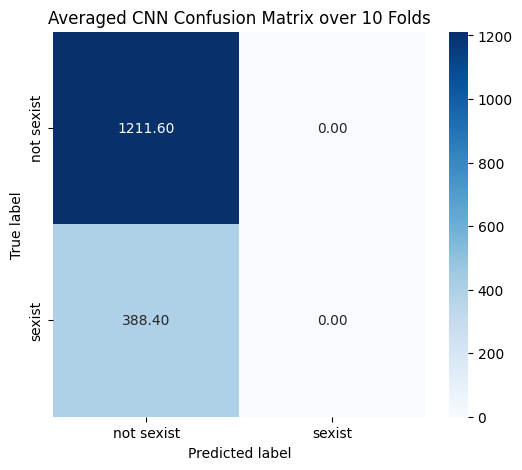


--- Averaged CNN Learning Curves ---


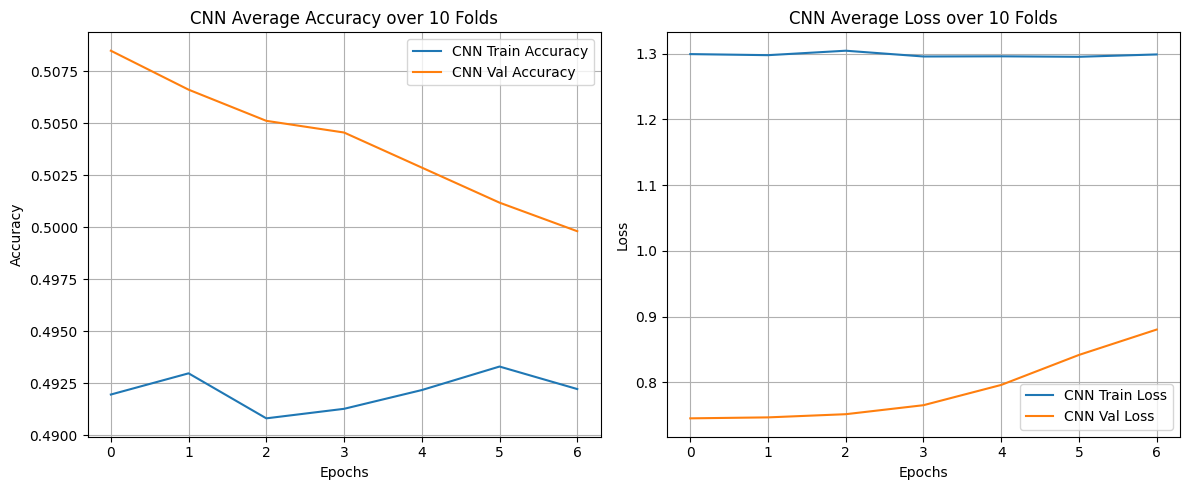

In [26]:
print("\n--- Training CNN Model ---")

# K-Fold Loop for CNN
for fold, (train_index, test_index) in enumerate(skf.split(X_pad_train, y_encoded_train)):
    print(f"\n CNN - Fold {fold + 1}/{n_splits}...")

    X_train_cnn, X_test_cnn = X_pad_train[train_index], X_pad_train[test_index]
    y_train_cnn, y_test_cnn = y_encoded_train[train_index], y_encoded_train[test_index]

    # Debugging prints
    # print(f"  X_train_cnn shape: {X_train_cnn.shape}, dtype: {X_train_cnn.dtype}")
    # print(f"  y_train_cnn shape: {y_train_cnn.shape}, dtype: {y_train_cnn.dtype}")
    # print(f"  Max value in X_train_cnn: {np.max(X_train_cnn)}") # Should be less than input_dim
    # print(f"  Min value in X_train_cnn: {np.min(X_train_cnn)}") # Should be 0 or positive
    # print(f"  Expected Embedding input_dim: {VOCAB_SIZE_DEEP_LEARNING}")
    # print(f"  Expected Embedding input_length: {MAX_SEQUENCE_LENGTH}")


    # Define CNN model (re-initialize for each fold to ensure fresh weights)
    cnn_model = build_cnn_model(VOCAB_SIZE_DEEP_LEARNING, MAX_SEQUENCE_LENGTH)

    # Print Model Summary (only once, for the first fold)
    if fold == 0:
        print("\n--- CNN Model Summary ---")
        cnn_model.summary()
        print("-" * 30)

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=0, min_lr=1e-5)
    lr_logger_callback = LearningRateLogger() # To get the learning rate at each fold

    # Train the model (Epochs for training over each fold)
    cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn,
                                 epochs=10,
                                 batch_size=128,
                                 callbacks=[early_stopping, lr_scheduler, lr_logger_callback],
                                 validation_data=(X_test_cnn, y_test_cnn),
                                 verbose=1)

    # Model Performance (Accuracy, Precision, Recall, F1) per fold
    # Returns: loss, accuracy, precision and recall
    cnn_loss, cnn_acc, cnn_precision, cnn_recall = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

    # Calculate F1-score
    cnn_f1 = 2 * (cnn_precision * cnn_recall) / (cnn_precision + cnn_recall + 1e-7) # Add epsilon to avoid div by zero

    results["CNN"].append(cnn_acc)

    print(f"    CNN Fold {fold + 1} Metrics - Accuracy: {cnn_acc:.4f}, Precision: {cnn_precision:.4f}, Recall: {cnn_recall:.4f}, F1: {cnn_f1:.4f}")

    # Confusion Matrix per fold
    y_pred_probs_cnn = cnn_model.predict(X_test_cnn, verbose=0)
    y_pred_cnn = (y_pred_probs_cnn > 0.8).astype(int)
    current_cm = confusion_matrix(y_test_cnn, y_pred_cnn)
    conf_matrix_sum_cnn += current_cm # Accumulate for averaging


    # Accumulate history for averaging later
    # Ensure all metrics from cnn_history.history are captured
    for metric_name, values in cnn_history.history.items():
        if metric_name in avg_histories["CNN"]:
            avg_histories["CNN"][metric_name].append(values)
        else:
            print(f"Warning: Metric '{metric_name}' not pre-initialized for CNN history.")

# Post-Loop Processing for Averaged Results and Plots

# Average CNN histories
print("\n--- Averaging CNN Histories ---")
for metric, all_runs_values in avg_histories["CNN"].items():

    # Pad shorter histories to the minimum length (due to EarlyStopping)
    min_len = min(len(run_values) for run_values in all_runs_values)
    trimmed_values = [run_values[:min_len] for run_values in all_runs_values]
    avg_histories["CNN"][metric] = np.mean(trimmed_values, axis=0)

# Calculate and print average results for CNN
avg_accuracy_cnn = np.mean(results["CNN"])
std_accuracy_cnn = np.std(results["CNN"])
print(f"\nAverage Accuracy for CNN over {n_splits} folds: {avg_accuracy_cnn:.4f} ± {std_accuracy_cnn:.4f}")

# Averaged Confusion Matrix Plot
print("\n--- Averaged CNN Confusion Matrix ---")
avg_cm = conf_matrix_sum_cnn / n_splits # Average the accumulated confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Averaged CNN Confusion Matrix over {n_splits} Folds')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Averaged Plots for Model Accuracy and Model Loss over All Epochs
print("\n--- Averaged CNN Learning Curves ---")
plt.figure(figsize=(12, 5))

# Plot Average Accuracy
plt.subplot(1, 2, 1)
plt.plot(avg_histories["CNN"]['accuracy'], label='CNN Train Accuracy')
plt.plot(avg_histories["CNN"]['val_accuracy'], label='CNN Val Accuracy')
plt.title(f'CNN Average Accuracy over {n_splits} Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Average Loss
plt.subplot(1, 2, 2)
plt.plot(avg_histories["CNN"]['loss'], label='CNN Train Loss')
plt.plot(avg_histories["CNN"]['val_loss'], label='CNN Val Loss')
plt.title(f'CNN Average Loss over {n_splits} Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Plot Average Precision/Recall
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(avg_histories["CNN"]['precision'], label='CNN Train Precision')
# plt.plot(avg_histories["CNN"]['val_precision'], label='CNN Val Precision')
# plt.title(f'CNN Average Precision over {n_splits} Folds')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.legend()
# plt.grid(True)
# plt.subplot(1, 2, 2)
# plt.plot(avg_histories["CNN"]['recall'], label='CNN Train Recall')
# plt.plot(avg_histories["CNN"]['val_recall'], label='CNN Val Recall')
# plt.title(f'CNN Average Recall over {n_splits} Folds')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### LSTM

In [27]:
shap_values_list = []
test_data_list = []

In [ ]:
conf_matrix_sum_lstm = np.zeros((2, 2))

for fold, (train_index, test_index) in enumerate(skf.split(X_pad_train, y_encoded_train)):
    print(f"LSTM - Fold {fold + 1}/{n_splits}...")

    X_train_lstm, X_test_lstm = X_pad_train[train_index], X_pad_train[test_index]
    y_train_lstm, y_test_lstm = y_encoded_train[train_index], y_encoded_train[test_index]

    # Define LSTM model (re-initialize for each fold)
    lstm_model = Sequential([
        Embedding(input_dim=VOCAB_SIZE_DEEP_LEARNING, output_dim=128),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        LSTM(64),
        Dense(1, activation='sigmoid', dtype='float32')
    ])

    if fold == 0:
        print("\n--- LSTM Model Summary ---")
        lstm_model.summary()
        print("-" * 30)

    # Compile LSTM model with Precision and Recall metrics
    lstm_model.compile(optimizer=Adam(learning_rate=0.0009),
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    early_stopping = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=0, min_lr=1e-5)
    lr_logger_callback = LearningRateLogger()

    lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=128,
                                  callbacks=[early_stopping, lr_scheduler, lr_logger_callback],
                                  validation_data=(X_test_lstm, y_test_lstm), verbose=1)


    #Required for SHAP analysis
    # Initialize the DeepExplainer with the trained model and its corresponding background data
    explainer = shap.KernelExplainer(lstm_model, X_train_lstm)

    # Select some test data from this fold to explain
    X_test_to_explain = X_test_lstm[:10]

    # Calculate SHAP values for the selected examples from this fold
    shap_values = explainer.shap_values(X_test_to_explain)

    # You can now process or store the shap_values for this fold
    shap_values_list.append(shap_values)
    test_data_list.append(X_test_to_explain)

    lstm_loss, lstm_acc, lstm_precision, lstm_recall = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)

    lstm_f1 = 2 * (lstm_precision * lstm_recall) / (lstm_precision + lstm_recall + 1e-7)

    results["LSTM"].append(lstm_acc)

    print(f"    LSTM Fold {fold + 1} Metrics - Accuracy: {lstm_acc:.4f}, Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}, F1: {lstm_f1:.4f}")

    y_pred_probs_lstm = lstm_model.predict(X_test_lstm, verbose=0)
    y_pred_lstm = (y_pred_probs_lstm > 0.8).astype(int)
    current_cm = confusion_matrix(y_test_lstm, y_pred_lstm)
    # Renamed from cm_sums to conf_matrix_sum_lstm
    conf_matrix_sum_lstm += current_cm

    for metric_name, values in lstm_history.history.items():
        if metric_name in avg_histories["LSTM"]:
            avg_histories["LSTM"][metric_name].append(values)
        else:
           print(f"Warning: Metric '{metric_name}' not pre-initialized for LSTM history.")

# The rest of the code for averaging and plotting remains correct
print("\n--- Averaging LSTM Histories ---")
for metric, all_runs_values in avg_histories["LSTM"].items():
   min_len = min(len(run_values) for run_values in all_runs_values)
   trimmed_values = [run_values[:min_len] for run_values in all_runs_values]
   avg_histories["LSTM"][metric] = np.mean(trimmed_values, axis=0)

avg_accuracy_lstm = np.mean(results["LSTM"])
std_accuracy_lstm = np.std(results["LSTM"])
print(f"\nAverage Accuracy for LSTM over {n_splits} folds: {avg_accuracy_lstm:.4f} ± {std_accuracy_lstm:.4f}")

print("\n--- Averaged LSTM Confusion Matrix ---")
# Renamed from cm_sums to conf_matrix_sum_lstm
avg_cm_lstm = conf_matrix_sum_lstm / n_splits
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_lstm, annot=True, fmt=".2f", cmap="Blues",
           xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Averaged LSTM Confusion Matrix over {n_splits} Folds')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print("\n--- Averaged LSTM Learning Curves ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_histories["LSTM"]['accuracy'], label='LSTM Train Accuracy')
plt.plot(avg_histories["LSTM"]['val_accuracy'], label='LSTM Val Accuracy')
plt.title(f'LSTM Average Accuracy over {n_splits} Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_histories["LSTM"]['loss'], label='LSTM Train Loss')
plt.plot(avg_histories["LSTM"]['val_loss'], label='LSTM Val Loss')
plt.title(f'LSTM Average Loss over {n_splits} Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

LSTM - Fold 1/10...

--- LSTM Model Summary ---


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

------------------------------
Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7391 - loss: 0.5551 - precision: 0.3482 - recall: 0.0861 - val_accuracy: 0.8306 - val_loss: 0.4173 - val_precision: 0.8031 - val_recall: 0.3995 - learning_rate: 9.0000e-04
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8507 - loss: 0.3686 - precision: 0.7712 - recall: 0.5524 - val_accuracy: 0.8369 - val_loss: 0.3953 - val_precision: 0.8396 - val_recall: 0.4046 - learning_rate: 9.0000e-04
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8690 - loss: 0.3220 - precision: 0.8084 - recall: 0.6070 - val_accuracy: 0.8406 - val_loss: 0.3869 - val_precision: 0.7608 - val_recall: 0.5000 - learning_rate: 9.0000e-04
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8879 - loss: 0.2876 - precision: 0.8194 - recall: 0.6847 - val_accuracy: 0.8419 - val_loss: 0.4114 - val_precision: 0.7437 - val_recall: 0.5309 - learning_rate: 9.0000e-04
Epoch 5/5
113/11

  0%|          | 0/10 [00:00<?, ?it/s]

#Pre-Trained BERTweet

In [ ]:
# Initializing BERTweet Sexism Detector
print("--- Initializing BERTweet Sexism Detector ---")

tokenizer = AutoTokenizer.from_pretrained("NLP-LTU/bertweet-large-sexism-detector")
model = AutoModelForSequenceClassification.from_pretrained("NLP-LTU/bertweet-large-sexism-detector")

# Create a Hugging Face pipeline for text classification.
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Encode the true labels from test_df for comparison
y_true_encoded = label_encoder.transform(test_df['label_sexist'])

#  Performing Predictions on the Test Dataset
print("\n--- Performing Predictions on the Test Dataset ---")

# Get predictions for all texts in the test_df
# The pipeline returns a list of dictionaries, so we extract the 'label'
texts_to_predict = test_df['text'].tolist()
print(f"Number of texts to predict: {len(texts_to_predict)}")

predictions_raw = classifier(texts_to_predict)
print(f"Length of predictions_raw (from classifier): {len(predictions_raw)}")
print(f"First 5 raw predictions: {predictions_raw[:5]}") # Debug print

# Extract predicted labels and scores
predicted_labels_raw = [p['label'] for p in predictions_raw]
prediction_scores = [p['score'] for p in predictions_raw]
print(f"Length of predicted_labels_raw (extracted labels): {len(predicted_labels_raw)}")
print(f"First 5 extracted labels: {predicted_labels_raw[:5]}") # Debug print


# Map the generic labels ('LABEL_0', 'LABEL_1') to your human-readable labels ('not sexist', 'sexist')
# Based on the model card for 'NLP-LTU/bertweet-large-sexism-detector',
# it's highly likely the model directly outputs 'not sexist' and 'sexist' strings.
# ive directly used these labels as they match what label_encoder expects.
y_pred_mapped = predicted_labels_raw # Direct assignment, assuming labels are already in desired format

print(f"Length of y_pred_mapped (after mapping): {len(y_pred_mapped)}")
print(f"First 5 mapped labels: {y_pred_mapped[:5]}") # Debug print

y_pred_encoded = label_encoder.transform(y_pred_mapped)
print(f"Length of y_pred_encoded (after label encoding): {len(y_pred_encoded)}")


# Evaluate Model Performance
print("\n--- BERTweet Model Performance on Test Set ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_encoded, y_pred_encoded, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('BERTweet Sexism Detector Confusion Matrix on Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nBERTweet Model evaluation on the test dataset complete.")

#Bias Fine-tuning

In [ ]:
def apply_smote(X_train, y_train):
    # Ensure X_train is not empty before applying SMOTE
    if X_train.shape[0] > 0 and len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42)
        # Use a try-except block in case SMOTE fails on a particular fold
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            return X_resampled, y_resampled
        except ValueError as e:
            print(f"Warning: SMOTE could not be applied to this fold. Skipping resampling. Error: {e}")
            return X_train, y_train
    else:
        print("Warning: Training data for this fold is empty or contains only one class. Skipping SMOTE.")
        return X_train, y_train


for fold, (train_index, test_index) in enumerate(skf.split(X_text_train, y_encoded_train)):
    print(f"\nNaive Bayes (Recall-focused) - Fold {fold + 1}/{n_splits}...")

    # Ensure X_text_train is in CSR format
    X_text_train_csr = X_text_train.tocsr()

    X_train_nbft, X_test_nbft = X_text_train_csr[train_index], X_text_train_csr[test_index]
    y_train_nbft, y_test_nbft = y_encoded_train[train_index], y_encoded_train[test_index]

    # --- Apply SMOTE to the training data of the current fold ---
    X_train_resampled, y_train_resampled = apply_smote(X_train_nbft, y_train_nbft)

    # Check shape after resampling
    print(f"  Training data shape before SMOTE: {X_train_nbft.shape}, Minority class count: {np.sum(y_train_nbft == 1)}")
    print(f"  Training data shape after SMOTE: {X_train_resampled.shape}, Minority class count: {np.sum(y_train_resampled == 1)}")

    # --- Use class_prior=[0.5, 0.5] in the model ---
    nbft_model = MultinomialNB(class_prior=[0.5, 0.5])
    nbft_model.fit(X_train_resampled, y_train_resampled)

    y_pred_nbft = nbft_model.predict(X_test_nb)
    acc_nbft = accuracy_score(y_test_nbft, y_pred_nbft)
    results["NBft"].append(acc_nbft)

    precision_nbft_f, recall_nbft_f, f1_nbft_f, _ = precision_recall_fscore_support(y_test_nbft, y_pred_nbft, average='binary', pos_label=1)
    precision_list_nbft.append(precision_nbft_f)
    recall_list_nbft.append(recall_nbft_f)
    f1_list_nbft.append(f1_nbft_f)
    conf_matrix_sum_nbft += confusion_matrix(y_test_nbft, y_pred_nbft)

    print(f"    Recall-focused NBft - Accuracy: {acc_nbft:.4f}, Precision: {precision_nbft_f:.4f}, Recall: {recall_nbft_f:.4f}, F1 Score: {f1_nbft_f:.4f}")

    # --- Threshold Adjustment Demonstration ---
    # This part shows how to manually adjust the threshold to prioritize recall
    y_pred_probs = nbft_model.predict_proba(X_test_nbft)[:, 1]
    threshold = 0.3
    y_pred_nbft_recall_tuned = (y_pred_probs > threshold).astype(int)

    precision_nbft_f_tuned, recall_nbft_f_tuned, f1_nbft_f_tuned, _ = precision_recall_fscore_support(y_test_nbft, y_pred_nbft_recall_tuned, average='binary', pos_label=1)

    print(f"--- Results with Threshold Adjusted to {threshold} ---")
    print(f"Tuned Precision: {precision_nbft_f_tuned:.4f}, Tuned Recall: {recall_nbft_f_tuned:.4f}, Tuned F1 Score: {f1_nbft_f_tuned:.4f}")

# Calculate and print average results for the recall-focused NBft
avg_accuracy_nbft = np.mean(results["NBft"])
std_accuracy_nbft = np.std(results["NBft"])
avg_precision_nbft = np.mean(precision_list_nbft)
avg_recall_nbft = np.mean(recall_list_nbft)
avg_f1_nbft = np.mean(f1_list_nbft)

print(f"\nAverage Accuracy for Recall-focused NBft over {n_splits} folds: {avg_accuracy_nbft:.4f} ± {std_accuracy_nbft:.4f}")
print(f"    Avg Precision: {avg_precision_nbft:.4f}, Avg Recall: {avg_recall_nbft:.4f}, Avg F1 Score: {avg_f1_nbft:.4f}")

# Plotting average confusion matrix for recall-focused NBft
avg_conf_matrix_nbft = conf_matrix_sum_nbft / n_splits
conf_matrix_custom_nbft = np.array([[avg_conf_matrix_nbft[1, 1], avg_conf_matrix_nbft[0, 1]],
                                         [avg_conf_matrix_nb[1, 0], avg_conf_matrix_nbft[0, 0]]], dtype=int)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom_nbft, annot=True, fmt="d", cmap="Blues",
            yticklabels=["Actual Sexist", "Actual Not Sexist"],
            xticklabels=["Predicted Sexist", "Predicted Not Sexist"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Recall-focused Naive Bayes Average Confusion Matrix")
plt.show()
print("Recall-focused Naive Bayes Average Confusion Matrix:\n", conf_matrix_custom_nbft)

##SHAP Explainability

In [ ]:
# Initialize the DeepExplainer with the model and background data
explainer = shap.DeepExplainer(lstm_model, X_pad_train)

# Select data to explain (the first 10)
X_test_to_explain = X_pad_test[:10]

# Calculate SHAP values for the selected examples
shap_values = explainer.shap_values(X_test_to_explain)

#Define the mapping from token IDs back to words
word_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_index.items()}

#Define the helper function to map SHAP values to words
def get_words_from_ids(ids):
    # This will return a list of words corresponding to the token IDs
    return [index_to_word.get(i, "") for i in ids]

# Select the data point you want to explain
test_instance_index = 0
test_data_to_explain = X_pad_test[test_instance_index:test_instance_index+1]

# 4. Calculate the SHAP values for this specific data point
shap_values = explainer.shap_values(test_data_to_explain)

# 5. Generate and display the waterfall plot
# This plot will show the contribution of each word to the model's output
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0][0], # SHAP values for the first class of the first instance
    base_values=explainer.expected_value[0],
    data=test_data_to_explain[0],
    feature_names=get_words_from_ids(test_data_to_explain[0])
))

# Evaluating the Models

In [ ]:
# Plot CNN
if "CNN" in avg_histories and avg_histories["CNN"]["accuracy"].size > 0: # Check if data exists
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(avg_histories["CNN"]['accuracy'], label='CNN Train Acc')
    plt.plot(avg_histories["CNN"]['val_accuracy'], label='CNN Val Acc')
    plt.title('CNN Average Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(avg_histories["CNN"]['loss'], label='CNN Train Loss')
    plt.plot(avg_histories["CNN"]['val_loss'], label='CNN Val Loss')
    plt.title('CNN Average Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.suptitle("CNN Averaged Learning Curves Across Folds", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Plot LSTM
if "LSTM" in avg_histories and avg_histories["LSTM"]["accuracy"].size > 0:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(avg_histories["LSTM"]['accuracy'], label='LSTM Train Acc')
    plt.plot(avg_histories["LSTM"]['val_accuracy'], label='LSTM Val Acc')
    plt.title('LSTM Average Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(avg_histories["LSTM"]['loss'], label='LSTM Train Loss')
    plt.plot(avg_histories["LSTM"]['val_loss'], label='LSTM Val Loss')
    plt.title('LSTM Average Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.suptitle("LSTM Averaged Learning Curves Across Folds", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot BERT
# BERT typically runs for fewer epochs. Check for valid data before plotting.
if "BERT" in avg_histories and avg_histories["BERT"]["accuracy"].size > 0:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(avg_histories["BERT"]['accuracy'], label='BERT Train Acc')
    plt.plot(avg_histories["BERT"]['val_accuracy'], label='BERT Val Acc')
    plt.title('BERT Average Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(avg_histories["BERT"]['loss'], label='BERT Train Loss')
    plt.plot(avg_histories["BERT"]['val_loss'], label='BERT Val Loss')
    plt.title('BERT Average Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.suptitle("BERT Averaged Learning Curves Across Folds", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

I tried to implement the GLoVe embedder into my models by using the pre-trained GloVe embeddings, my models (LSTM and CNN) should have benefit from semantic knowledge captured in those embeddings, which I thought would improve the model's performance, especially when training data is limited. Unfortunatley, this caused the predictions to drastically overfit so I removed them